<img src="https://www.scienze.unimib.it/sites/sc02/files/scientifica_logo_scuola.png" align="left" width="150px" height="160px">

<h1>
Text Mining Project <br>
Task 1: <b>Text Classification</b>
on <a href="https://data.mendeley.com/datasets/9rw3vkcfy4/6">Web of Science</a> Dataset
</h1>

<h3>Students: Arizzi Sara 845374, Bidone Federico 892054</h3>


# Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from itertools import chain, islice

import requests
from zipfile import ZipFile
from io import BytesIO

In [ ]:
# Download dataset directly from <a href="https://data.mendeley.com/public-files/datasets/9rw3vkcfy4/files/c9ea673d-5542-44c0-ab7b-f1311f7d61df/file_downloaded">source</a>

zip_file_url = "https://data.mendeley.com/public-files/datasets/9rw3vkcfy4/files/c9ea673d-5542-44c0-ab7b-f1311f7d61df/file_downloaded"

r = requests.get(zip_file_url)
if r.ok:
  z = ZipFile(BytesIO(r.content))
  z.extractall(".")
else:
  print("Request to source has gone wrong")

In [ ]:
#Matching Number - Label

df = pd.read_excel("Meta-data/Data.xlsx")

YL1_labels = dict(zip(df.Y1, df.Domain))
YL1_labels = {k: v.strip() for k, v in YL1_labels.items()}

Y_labels = dict(zip(df.Y, df.area))
Y_labels = {k: v.strip() for k, v in Y_labels.items()}

In [ ]:
# Read Data
# Read X: train text
f = open("WOS46985/X.txt", "r")
all = f.read()
X = all.split("\n")

# Read Y: subdomain (134 in total)
f = open("WOS46985/Y.txt", "r")
all = f.read()
Y = all.split("\n")

# Read YL1: domain, or parent label (7 in total)
f = open("WOS46985/YL1.txt", "r")
all = f.read()
YL1 = all.split("\n")

# Read YL2: child label (53 in total)
f = open("WOS46985/YL2.txt", "r")
all = f.read()
YL2 = all.split("\n")

# Data Exploration

In [ ]:
len(set(Y)) # subdomain

134

In [ ]:
len(set(YL1)) # domain parent label

7

In [ ]:
len(set(YL2)) # child label

53

## Observation Example

In [ ]:
X[1]

"(beta-amyloid (A beta) and tau pathology become increasingly prevalent with age, however, the spatial relationship between the two pathologies remains unknown. We examined local (same region) and non-local (different region) associations between these 2 aggregated proteins in 46 normal older adults using [F-18]AV-1451 (for tau) and [C-11]PiB (for A beta) positron emission tomography (PET) and 1.5 T magnetic resonance imaging (MRI) images. While local voxelwise analyses showed associations between PiB and AV-1451 tracer largely in the temporal lobes, k-means clustering revealed that some of these associations were driven by regions with low tracer retention. We followed this up with a whole-brain region-by-region (local and non-local) partial correlational analysis. We calculated each participant's mean AV-1451 and PiB uptake values within 87 regions of interest (ROI). Pairwise ROI analysis demonstrated many positive PiB AV-1451 associations. Importantly, strong positive partial correl

In [ ]:
Y_labels.get(int(Y[0])) # subdomain

'Symbolic computation'

In [ ]:
YL1_labels.get(int(YL1[0])) # domain

'CS'

In [ ]:
Y_labels.get(int(YL2[0])) # child label

'Symbolic computation'

In [ ]:
# Number of Samples

len(X)

46985

In [ ]:
# Number of Classes
len(set(YL1))

7

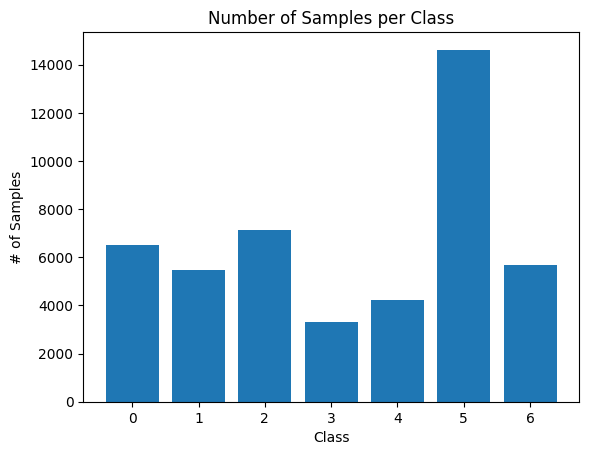

In [ ]:
# Number of Samples per Class

c = Counter(YL1)
plt.bar(
  list(map(int, c.keys())),
  list(c.values())
)
plt.title("Number of Samples per Class")
plt.xlabel("Class")
plt.ylabel("# of Samples")
plt.show()

In [ ]:
df

,Y1,Y2,Y,Domain,area,keywords,Abstract
0,0,12,12,CS,Symbolic computation,(2+1)-dimensional non-linear optical waves; e...,(2 + 1)-dimensional non-linear optical waves t...
1,5,2,74,Medical,Alzheimer's Disease,Aging; Tau; Amyloid; PET; Alzheimer's disease...,(beta-amyloid (A beta) and tau pathology becom...
2,4,7,68,Civil,Green Building,LED lighting system; PV system; Distributed l...,(D)ecreasing of energy consumption and environ...
3,1,10,26,ECE,Electric motor,NdFeB magnets; Electric motor; Electric vehic...,(Hybrid) electric vehicles are assumed to play...
4,5,43,115,Medical,Parkinson's Disease,Parkinson's disease; dyskinesia; adenosine A(...,"(L)-3,4-Dihydroxyphenylalanine ((L)-DOPA) rema..."
...,...,...,...,...,...,...,...
46980,5,50,122,Medical,Sports Injuries,Karate; Verletzungsrisiko; Sportverletzung; P...,Zusammenfassung Hintergrund: Karate erfreut si...
46981,0,15,15,CS,Data structures,Z-Wave; Wireless; Embedded systems; Internet ...,Z-Wave is an implementation of home automation...
46982,5,38,110,Medical,Cancer,Antifouling biosensor; Peptide; Electrochemis...,Zwitterionic peptides were anchored to a condu...
46983,0,10,10,CS,Distributed computing,High Performance Computing; Parallel Computin...,ZY-3 has been acquiring high quality imagery s...


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

In [ ]:
# Filter Dataframe
df = df[['Abstract', 'Y1']]
df

,Abstract,Y1
0,(2 + 1)-dimensional non-linear optical waves t...,0
1,(beta-amyloid (A beta) and tau pathology becom...,5
2,(D)ecreasing of energy consumption and environ...,4
3,(Hybrid) electric vehicles are assumed to play...,1
4,"(L)-3,4-Dihydroxyphenylalanine ((L)-DOPA) rema...",5
...,...,...
46980,Zusammenfassung Hintergrund: Karate erfreut si...,5
46981,Z-Wave is an implementation of home automation...,0
46982,Zwitterionic peptides were anchored to a condu...,5
46983,ZY-3 has been acquiring high quality imagery s...,0


In [ ]:
# Dataset class definition
class AbstractsDataset(Dataset):
    def __init__(self, abstracts, labels, tokenizer, max_len):
        self.abstracts = abstracts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.abstracts)

    def __getitem__(self, item):
        abstract = str(self.abstracts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            abstract,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'abstract_text': abstract,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Data preparation
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 512
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = AbstractsDataset(
    abstracts=train_df.Abstract.to_numpy(),
    labels=train_df.Y1.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
test_dataset = AbstractsDataset(
    abstracts=test_df.Abstract.to_numpy(),
    labels=test_df.Y1.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

In [ ]:
# Model creation
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Training parameters
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=1e-5)

In [ ]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Function to calculate accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    print(f'Epoch {epoch + 1}/{EPOCHS} - Loss: {total_loss / len(train_loader)}')

Epoch 1/5 - Loss: 0.5488975765888995
Epoch 2/5 - Loss: 0.29303217057297204
Epoch 3/5 - Loss: 0.22406971797485775
Epoch 4/5 - Loss: 0.16703676248246685
Epoch 5/5 - Loss: 0.12890144164101816


In [ ]:
# Evaluation
model.eval()
predictions, true_labels = [], []
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions.append(logits.argmax(dim=-1).cpu().numpy())
    true_labels.append(labels.cpu().numpy())
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1328
           1       0.94      0.95      0.94      1072
           2       0.86      0.90      0.88      1387
           3       0.92      0.88      0.90       662
           4       0.91      0.91      0.91       853
           5       0.92      0.89      0.90      2918
           6       0.86      0.92      0.89      1177

    accuracy                           0.91      9397
   macro avg       0.91      0.91      0.91      9397
weighted avg       0.91      0.91      0.91      9397



In [ ]:
# Create a dataset for the entire dataframe
full_dataset = AbstractsDataset(
    abstracts=df.Abstract.to_numpy(),
    labels=df.Y1.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# DataLoader for the complete dataset
full_loader = DataLoader(full_dataset, batch_size=16, shuffle=False)

# Use the model to make predictions on the entire dataset
model.eval()
all_predictions = []
for batch in full_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions = logits.argmax(dim=-1).cpu().numpy()
    all_predictions.extend(predictions)

# Compare the predictions with the original labels
original_labels = df.Y1.to_numpy()

In [ ]:
print(classification_report(original_labels, all_predictions, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6']))

              precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98      6514
     Class 1       0.98      0.99      0.98      5483
     Class 2       0.95      0.97      0.96      7142
     Class 3       0.98      0.96      0.97      3297
     Class 4       0.97      0.97      0.97      4237
     Class 5       0.98      0.95      0.96     14625
     Class 6       0.93      0.98      0.95      5687

    accuracy                           0.97     46985
   macro avg       0.97      0.97      0.97     46985
weighted avg       0.97      0.97      0.97     46985

